# Plots comparing estimators in various scenarios

In [1]:
# First read in data
# %%
import pickle
import numpy as np # noqa
import matplotlib.pyplot as plt # noqa
# Plot results
import matplotlib.lines as mlines
from matplotlib.legend import Legend
import sys
import torch
from torch import distributions

font = {'size'   : 14}

sys.path.append("..")
from functions.objective_funcs_torch import get_dat_vals_impute
from functions.estimators_torch import kliep_miss_wrap, kliep_naive_wrap
from functions.np_classifier_torch import cutoff_bin
from functions.pipeline_funcs import get_ci

plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["axes.facecolor"] = "White"
plt.rcParams["savefig.facecolor"] = "White"

plt.rc('font',**{'family':'sans-serif', 'size': 14})
#If fonttype = 1 doesn't work with LaTeX, try fonttype 42.
plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)

unif = distributions.Uniform(0,1)


def mv_sampler_creator(n, dist):
    def sampler():
        return dist.sample((n,))
    return sampler


def mv_mix_sampler_creator(n, dist_1, dist_2, p=0.5):
    def sampler():
        u = distributions.Binomial(n, p).sample((1,))[0]
        samp_1 = dist_1.sample((int(u),))
        samp_2 = dist_2.sample((int(n-u),))
        return torch.concat([samp_1, samp_2])
    return sampler

# DRE Tests
## Correctly Specified Case
Here we enter the multi-dimensional case with 
$Z^+\sim N(\mu^+,\Sigma),~Z^-\sim N(\mu^+,\Sigma)$ where $\mu^+=(0,0,0,0,0)^T,\mu^-=(0.1,0.1,0.1,0.1,0.1)^T,$ and $\Sigma=I$

$\varphi^+(x)=\mathbb{1}_{\sum_{i=1}^5 x^{(i)}>0}$, $\varphi^-=0$


In [2]:
with open('../results/simulated_results/Vary_n_one_class_5dim_100sim_comp_diff=0.1_torch.pkl', 'rb') as handle:
    Output_8 = pickle.load(handle)

df = Output_8["Data"]
n = n = max(df["Simulation"])+1

df["MSD"] = (
    (df["Param0"]+0.1)**2+(df["Param1"]+0.1)**2+
    (df["Param2"]+0.1)**2+(df["Param3"]+0.1)**2+
    (df["Param4"]+0.1)**2
)
df_sum = df.groupby(["Data_Type", "Estimator"])[("MSD")].agg(
    [np.nanmean, np.std]
).reset_index()

df_sum.rename(columns={"nanmean": "MSD", "std": "MSD_std"},
              inplace=True)
df_sum["MSD_ste"] = df_sum["MSD_std"]/n**0.5
df_sum["MSD_upp"] = df_sum["MSD"]+1.96*df_sum["MSD_ste"]
df_sum["MSD_low"] = df_sum["MSD"]-1.96*df_sum["MSD_ste"]
df_sum["n"] = np.repeat(Output_8["Param"], 2)



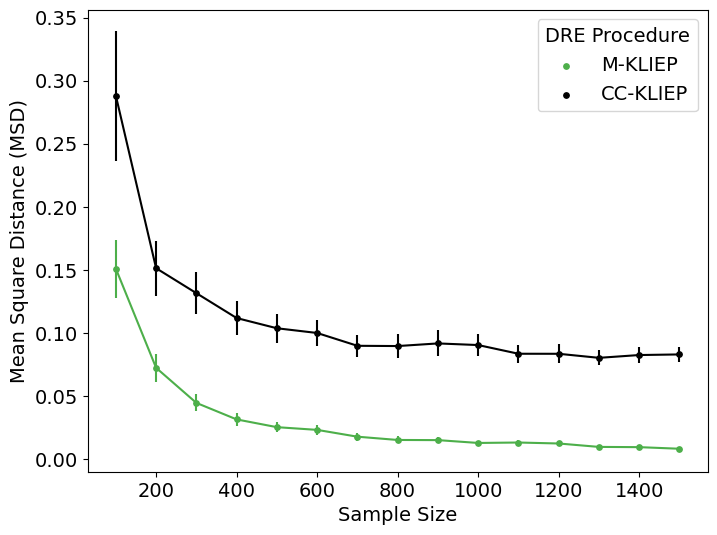

In [3]:
x = np.array(Output_8["Param"])
n_nxs = len(x)
cs=[u'#4daf4a',u'#000000']
markertype=["o"]*4+["^"]*4
order=[0,1]
fig, ax = plt.subplots(figsize=(8, 6))
labels = {"KLIEP Miss": "M-KLIEP", "KLIEP Naive": "CC-KLIEP"}
for i, key in enumerate(labels):
    # Filter data
    df_temp = df_sum[df_sum.Estimator == key]

    y1 = df_temp["MSD_upp"]
    y2 = df_temp["MSD_low"]
    y = df_temp["MSD"]
    error = df_temp["MSD_ste"]*2.58

    x_jit=x*(1+0.025)**i

    ax.scatter(x, y, label=labels[key], s=15,c=cs[i])
    ax.errorbar(x, y,error,color=cs[i])

ax.set(xlabel="Sample Size", ylabel="Mean Square Distance (MSD)")

ax.legend(title="DRE Procedure")
plt.savefig("../plots/5-dim_MSD_vary_n_one_class_miss.pdf", bbox_inches="tight", dpi=300)

# NP Classification
We now plot the results of the NP classification experiments. In each of these we used incorrectly specified models.
## 1st Misspecified Case
Here the set-up is

\begin{align*}
    p_1(z)&=\frac{1}{2} N\left(z;\begin{pmatrix}0 \\ 0\end{pmatrix},I \right)+
    \frac{1}{2} N\left(z;\begin{pmatrix}-1 \\ 4\end{pmatrix},I \right)\\
    p_0(z)&=\frac{1}{2} N\left(z;\begin{pmatrix}1 \\ 0\end{pmatrix},I \right)+
    \frac{1}{2} N\left(z;\begin{pmatrix}0 \\ 4\end{pmatrix}, I \right)
\end{align*}


where $N(z;\mu,\Sigma)$ is the PDF of a multivariate normal distribution with mean $\mu$ and variance $\Sigma$ evaluated at $z$.

In [4]:
with open('../results/simulated_results/NP_mixed_classif_aistat_100sim_.pkl', 'rb') as handle:
    Output = pickle.load(handle)
df = Output["Data"]
true_dat = torch.tensor(Output["True_r_res"])[:,:,0].T

n = max(df["Simulation"])+1
df_sum = (df.groupby(["Data_Type", "Estimator"])["power"]
                      .agg([lambda x: np.mean(x),
                            lambda x: np.std(x)]
                           )
                      .reset_index())

df_sum.rename(columns={"<lambda_0>": "Power", "<lambda_1>": "Power_std"},
                   inplace=True)

df_sum["Power_ste"] = df_sum["Power_std"]/n**0.5
df_sum["Power_upp"] = df_sum["Power"]+1.96*df_sum["Power_ste"]
df_sum["Power_low"] = df_sum["Power"]-1.96*df_sum["Power_ste"]
df_sum["n"] = np.repeat(Output["Param"], 2)


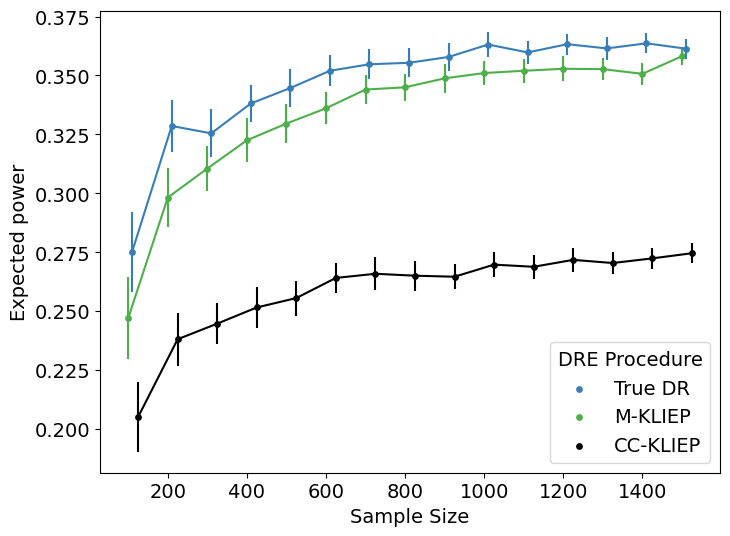

In [5]:
x = np.array(Output["Param"])
n_nxs = len(x)
cs=[u'#377eb8',u'#4daf4a',u'#000000']
order=[0,1]
fig, ax = plt.subplots(figsize=(8, 6))

diff=x[1]-x[0]
y=torch.mean(true_dat,0)
error=2.58*torch.std(true_dat,0)/true_dat.shape[0]**0.5
x_jit=x+diff*0.05*2
ax.scatter(x_jit, y, label="True DR", s=15,c=cs[0])
ax.errorbar(x_jit, y,error, color=cs[0])

labels = {"KLIEP Miss": "M-KLIEP", "KLIEP Naive": "CC-KLIEP"}
for i, key in enumerate(labels):

    # Filter data
    df_temp = df_sum[df_sum.Estimator == key]

    y1 = df_temp["Power_upp"]
    y2 = df_temp["Power_low"]
    y = df_temp["Power"]
    error = 2.58*df_temp["Power_ste"]
    
    x_jit=x+diff*0.25*i

    ax.scatter(x_jit, y, label=labels[key], s=15,c=cs[i+1])
    ax.errorbar(x_jit, y,error,color=cs[i+1])

ax.set(xlabel="Sample Size", ylabel="Expected power")

ax.legend(title="DRE Procedure")

plt.savefig("../plots/NP_expected Power_gauss_mix_vary_n_one_class.pdf",bbox_inches="tight", dpi=300)

Now we plot the Type I Error

In [31]:
with open('../results/simulated_results/NP_mixed_classif_aistat_100sim_.pkl', 'rb') as handle:
    Output = pickle.load(handle)
df = Output["Data"]
true_dat = torch.tensor(Output["True_r_res"])[:,:,1].T

n = max(df["Simulation"])+1
df_sum = (df.groupby(["Data_Type", "Estimator"])["alpha"]
                      .agg([lambda x: np.mean(x),
                            lambda x: np.std(x)]
                           )
                      .reset_index())

df_sum.rename(columns={"<lambda_0>": "Alpha", "<lambda_1>": "Alpha_std"},
                   inplace=True)

df_sum["Alpha_ste"] = df_sum["Alpha_std"]/n**0.5
df_sum["Alpha_upp"] = df_sum["Alpha"]+1.96*df_sum["Alpha_ste"]
df_sum["Alpha_low"] = df_sum["Alpha"]-1.96*df_sum["Alpha_ste"]
df_sum["n"] = np.repeat(Output["Param"], 2)

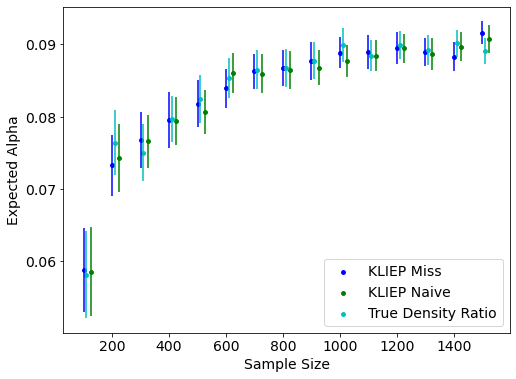

In [32]:
x = np.array(Output["Param"])
n_nxs = len(x)
colours=[u'b',u'g',u'c',u'r']*2
markertype=["o"]*4+["^"]*4
order=[0,1]
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(2):
    current_estimator = df_sum.Estimator[order[i]]
    # Filter data
    df_temp = df_sum[df_sum.Estimator == current_estimator]

    y1 = df_temp["Alpha_upp"]
    y2 = df_temp["Alpha_low"]
    y = df_temp["Alpha"]
    error = 2.58*df_temp["Alpha_ste"]
    diff=x[1]-x[0]
    x_jit=x+diff*0.25*i

    ax.scatter(x_jit, y, label=current_estimator, s=15, 
               marker=markertype[i],c=colours[i])
    ax.errorbar(x_jit, y,error, ls="none",ecolor=colours[i])
    

y=torch.mean(true_dat,0)
error=2.58*torch.std(true_dat,0)/true_dat.shape[0]**0.5
x_jit=x+diff*0.05*2
ax.scatter(x_jit, y, label="True Density Ratio", s=15, 
               marker=markertype[2],c=colours[2])
ax.errorbar(x_jit, y,error, ls="none",ecolor=colours[2])


ax.set(xlabel="Sample Size", ylabel="Expected Alpha")

ax.legend()


### Asymptotic Threshold Calibration
Here we read the results where we use a large number of points to choose the threshold to mimic "perfect" threshold choice for our estimate density ratio.

First we plot the Power

In [33]:
with open('../results/simulated_results/NP_mixed_classif_aistat_100sim_largeclassdat.pkl', 'rb') as handle:
    Output = pickle.load(handle)
df = Output["Data"]
true_dat = torch.tensor(Output["True_r_res"])[:,:,0].T

n = max(df["Simulation"])+1
df_sum = (df.groupby(["Data_Type", "Estimator"])["power"]
                      .agg([lambda x: np.mean(x),
                            lambda x: np.std(x)]
                           )
                      .reset_index())

df_sum.rename(columns={"<lambda_0>": "Power", "<lambda_1>": "Power_std"},
                   inplace=True)

df_sum["Power_ste"] = df_sum["Power_std"]/n**0.5
df_sum["Power_upp"] = df_sum["Power"]+1.96*df_sum["Power_ste"]
df_sum["Power_low"] = df_sum["Power"]-1.96*df_sum["Power_ste"]
df_sum["n"] = np.repeat(Output["Param"], 2)


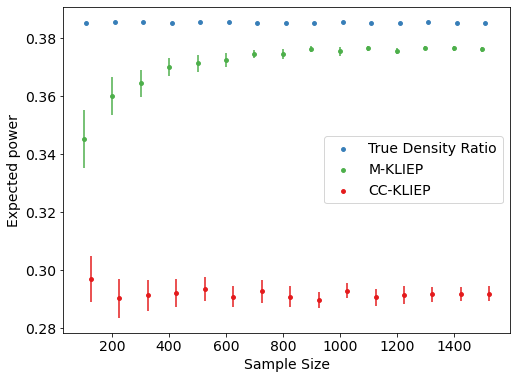

In [34]:
x = np.array(Output["Param"])
n_nxs = len(x)
cs=[u'#377eb8',u'#4daf4a', u'#e41a1c']
order=[0,1]
fig, ax = plt.subplots(figsize=(8, 6))

diff=x[1]-x[0]
y=torch.mean(true_dat,0)
error=2.58*torch.std(true_dat,0)/true_dat.shape[0]**0.5
x_jit=x+diff*0.05*2
ax.scatter(x_jit, y, label="True Density Ratio", s=15,c=cs[0])
ax.errorbar(x_jit, y,error, ls="none",ecolor=cs[0])

labels = {"KLIEP Miss": "M-KLIEP", "KLIEP Naive": "CC-KLIEP"}
for i, key in enumerate(labels):

    # Filter data
    df_temp = df_sum[df_sum.Estimator == key]

    y1 = df_temp["Power_upp"]
    y2 = df_temp["Power_low"]
    y = df_temp["Power"]
    error = 2.58*df_temp["Power_ste"]
    
    x_jit=x+diff*0.25*i

    ax.scatter(x_jit, y, label=labels[key], s=15,c=cs[i+1])
    ax.errorbar(x_jit, y,error, ls="none",ecolor=cs[i+1])

ax.set(xlabel="Sample Size", ylabel="Expected power")
ax.legend()

Now we plot the Type I error

In [35]:
with open('../results/simulated_results/NP_mixed_classif_aistat_100sim_largeclassdat.pkl', 'rb') as handle:
    Output = pickle.load(handle)
df = Output["Data"]
true_dat = torch.tensor(Output["True_r_res"])[:,:,1].T

n = max(df["Simulation"])+1
df_sum = (df.groupby(["Data_Type", "Estimator"])["alpha"]
                      .agg([lambda x: np.mean(x),
                            lambda x: np.std(x)]
                           )
                      .reset_index())

df_sum.rename(columns={"<lambda_0>": "Alpha", "<lambda_1>": "Alpha_std"},
                   inplace=True)

df_sum["Alpha_ste"] = df_sum["Alpha_std"]/n**0.5
df_sum["Alpha_upp"] = df_sum["Alpha"]+1.96*df_sum["Alpha_ste"]
df_sum["Alpha_low"] = df_sum["Alpha"]-1.96*df_sum["Alpha_ste"]
df_sum["n"] = np.repeat(Output["Param"], 2)

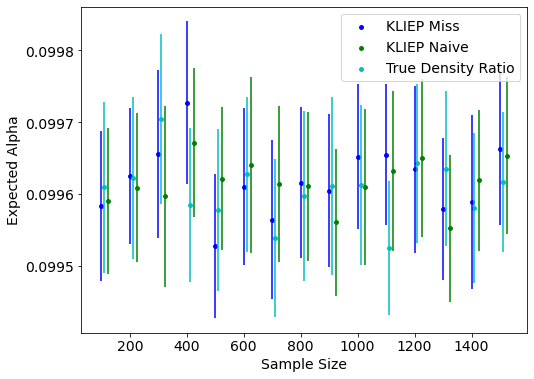

In [36]:
x = np.array(Output["Param"])
n_nxs = len(x)
colours=[u'b',u'g',u'c',u'r']*2
markertype=["o"]*4+["^"]*4
order=[0,1]
fig, ax = plt.subplots(figsize=(8, 6))

for i in range(2):
    current_estimator = df_sum.Estimator[order[i]]
    # Filter data
    df_temp = df_sum[df_sum.Estimator == current_estimator]

    y1 = df_temp["Alpha_upp"]
    y2 = df_temp["Alpha_low"]
    y = df_temp["Alpha"]
    error = 2.58*df_temp["Alpha_ste"]
    diff=x[1]-x[0]
    x_jit=x+diff*0.25*i

    ax.scatter(x_jit, y, label=current_estimator, s=15, 
               marker=markertype[i],c=colours[i])
    ax.errorbar(x_jit, y,error, ls="none",ecolor=colours[i])
    

y=torch.mean(true_dat,0)
error=2.58*torch.std(true_dat,0)/true_dat.shape[0]**0.5
x_jit=x+diff*0.05*2
ax.scatter(x_jit, y, label="True Density Ratio", s=15, 
               marker=markertype[2],c=colours[2])
ax.errorbar(x_jit, y,error, ls="none",ecolor=colours[2])


ax.set(xlabel="Sample Size", ylabel="Expected Alpha")

ax.legend()


### Single Sample Example
We now present the figure for a single example of the above procedure

In [6]:
# Set-up data generating functions
n_plus = 500
n_minus = 500
z_plus_0 = distributions.MultivariateNormal(
    torch.zeros(2), torch.eye(2))
z_plus_1 = distributions.MultivariateNormal(
    torch.tensor([-1., 4.]), torch.eye(2))


z_minus_0 = distributions.MultivariateNormal(
    torch.tensor([1., 0.]), torch.eye(2))
z_minus_1 = distributions.MultivariateNormal(
    torch.tensor([0., 4.]), torch.eye(2))


plus_gen = mv_mix_sampler_creator(n_plus, z_plus_0, z_plus_1, 0.5)

minus_gen = mv_mix_sampler_creator(n_minus, z_minus_0, z_minus_1, 0.5)

# Create miss_plus and miss_minus list
p_0 = 0.9


def temp_miss_func(x):
    return torch.where(x[:, 1] < 2., 0., p_0)

In [7]:
# Generate data
z_minus = minus_gen()
z_plus = plus_gen()
x_minus = z_minus.clone().detach()
x_plus = z_plus.clone().detach()

# Create corrupted data
u_plus = unif.sample((n_plus,))
x_plus[
    u_plus < temp_miss_func(z_plus), :
] = torch.nan

# Summarise data
dat_vals = get_dat_vals_impute(
    x_plus, x_minus, varphi_plus=temp_miss_func
)

lr=1*(0.7**(np.floor((np.arange(1000)+2)/50)))
# Perform DRE
out_kliep_miss = kliep_miss_wrap(dat_vals,lr=lr, maxiter=1000)
out_kliep_naive = kliep_naive_wrap(dat_vals,lr=lr, maxiter=1000)

out_tup = (out_kliep_miss, out_kliep_naive)

x_0_new = minus_gen()

In [8]:
# Create true density ratio function
from scipy.stats import multivariate_normal


def create_temp_func(theta):
    def temp_class_func(x):
        return torch.exp(x@theta).reshape(-1)
    return temp_class_func


# Construct classifiers for DR estimates and true DR
func_list = []
classif_list = []
for i in range(2):
    theta=out_tup[i]["par"]
    func_list.append(create_temp_func(theta))
    classif_list.append(cutoff_bin(func_list[i], 0.1, 0.1, x_0_new))

def true_r(x):
    return ((0.5*torch.exp(z_plus_0.log_prob(x))+0.5*torch.exp(z_plus_1.log_prob(x)))
            / (0.5*torch.exp(z_minus_0.log_prob(x))+0.5*torch.exp(z_minus_1.log_prob(x))))

func_list.append(true_r)
classif_list.append(cutoff_bin(true_r,0.1,0.1, x_0_new))

In [9]:
# Calculate Classification Boundary
x = torch.linspace(-4, 3, 1000)
y = torch.linspace(-4, 8, 1000)

X, Y = torch.meshgrid(x, y)

X_flat = X.reshape(-1)
Y_flat = Y.reshape(-1)


Z_list=[]
for i in range(3):
    Z_list.append(func_list[i](torch.vstack((X_flat, Y_flat)).T).reshape(1000,1000))

/home/cn21903/anaconda3/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


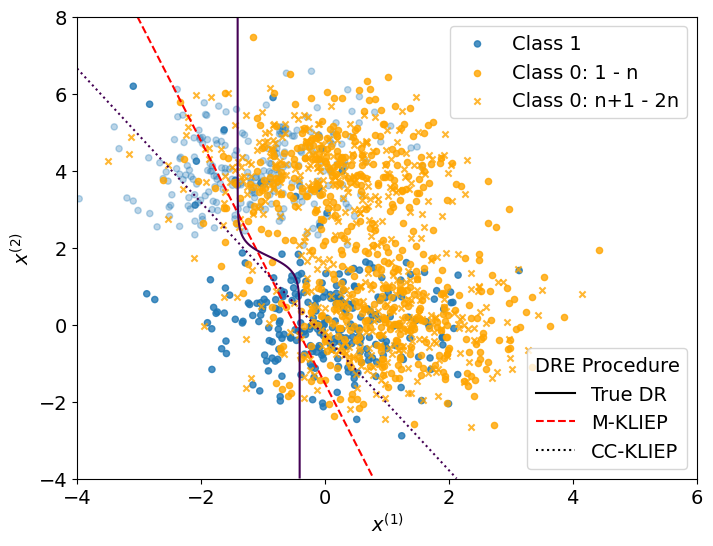

In [10]:
# Plot results
import matplotlib.lines as mlines
from matplotlib.legend import Legend

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8, 6))
alpha=np.where(np.isnan(x_plus[:,0]),0.3,0.8)

ax.scatter(x=z_plus[:,0],y=z_plus[:,1],alpha=alpha, s=20,label="Class 1")
ax.scatter(x=z_minus[:,0],y=z_minus[:,1],color="orange",alpha=0.8, s=20, label="Class 0: 1 - n")
ax.scatter(x=x_0_new[:,0],y=x_0_new[:,1],color="orange",marker="x", alpha=0.8,s=20,label="Class 0: n+1 - 2n")

ax.contour(X,Y,Z_list[0],levels=np.array([classif_list[0][0]]),
           linestyles= "dashed",colors=u"r")
ax.contour(X,Y,Z_list[1],levels=np.array([classif_list[1][0]]),
          linestyles="dotted")
ax.contour(X,Y,Z_list[2],levels=np.array([classif_list[2][0]]),
           linestyles="solid")


line1 = mlines.Line2D([], [],color=u"r",linestyle="dashed",label="M-KLIEP")
line2 = mlines.Line2D([], [],color="black",linestyle="dotted",label="CC-KLIEP")
line3 = mlines.Line2D([], [],color="black",linestyle="solid",label="True DR")


# Create a legend for the first line.
leg1 = ax.legend()

ax.legend(handles=[line3,line1,line2],loc="lower right",title="DRE Procedure")
ax.set(xlim=(-4,6),xlabel=r"$x^{(1)}$",ylabel=r"$x^{(2)}$")
ax.add_artist(leg1)

plt.savefig("../plots/NP_classification_Boundary_KLIEP.pdf",bbox_inches="tight", dpi=300)

## 2nd Misspecified Case
$$Z_1\sim N(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, 
\begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix})$$

$$Z_0\sim N(\begin{pmatrix} 1 \\ 1 \end{pmatrix}, 
\begin{pmatrix} 2 & 1\\ 1 & 1\end{pmatrix})$$

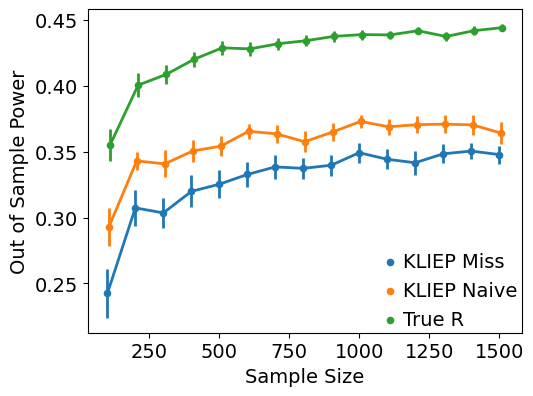

In [11]:
with open('../results/simulated_results/vary_diffvar_misspec_100sim_comp_diff=1_torch.pkl', 'rb') as handle:
    output = pickle.load(handle)
x = np.arange(100, 1501, 100)
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(output):
    power=torch.tensor(output[key]["poweralpha"])[:,:,0].T
    all_cis = get_ci(power, verbose=False)
    diff=x[1]-x[0]
    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, all_cis[0], label=key, s=20)
    ax.errorbar(x_jit, all_cis[0], all_cis[2]-all_cis[0],linewidth=2)

ax.set(xlabel="Sample Size", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)

### Single Sample Example

In [12]:
# Set-up data generating functions
n_plus = 500
n_minus = 500
# Generate data generating procedures
cov_mat = torch.tensor([[2, 1], [1, 1]]).float()
diff = 1

plus_dist = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
minus_dist = distributions.MultivariateNormal(torch.zeros(2)+diff, cov_mat)



plus_gen = mv_sampler_creator(n_plus, plus_dist)

minus_gen = mv_sampler_creator(n_minus, minus_dist)

p_0 = 0.8

# Create missing function
def miss_func(x):
    return torch.where(x[:, 1] > 0., p_0, 0.)


def true_r(x):
    return plus_dist.log_prob(x)-minus_dist.log_prob(x)


In [13]:
# Generate data
z_minus = minus_gen()
z_plus = plus_gen()
x_minus = z_minus.clone().detach()
x_plus = z_plus.clone().detach()

# Create corrupted data
u_plus = unif.sample((n_plus,))
x_plus[
    u_plus < miss_func(z_plus), :
] = torch.nan

# Summarise data
dat_vals = get_dat_vals_impute(
    x_plus, x_minus, varphi_plus=miss_func
)

# Perform DRE
out_kliep_miss = kliep_miss_wrap(
    dat_vals, maxiter=1000, opt_type="BFGS",
    f=lambda x:x, norm_fl=True)
out_kliep_naive = kliep_naive_wrap(
    dat_vals, maxiter=1000, opt_type="BFGS",
    f=lambda x:x, norm_fl=True)

out_tup = (out_kliep_miss, out_kliep_naive)

# Do NP classification and construct classifiers
z_0_new = minus_gen()
# Construct classifiers for DR estimates and true DR
func_list = []
classif_list = []
for i in range(2):
    func_list.append(out_tup[i]["r"])
    classif_list.append(cutoff_bin(func_list[i], 0.1, 0.1, z_0_new))

func_list.append(true_r)
classif_list.append(cutoff_bin(true_r,0.1,0.1, z_0_new))

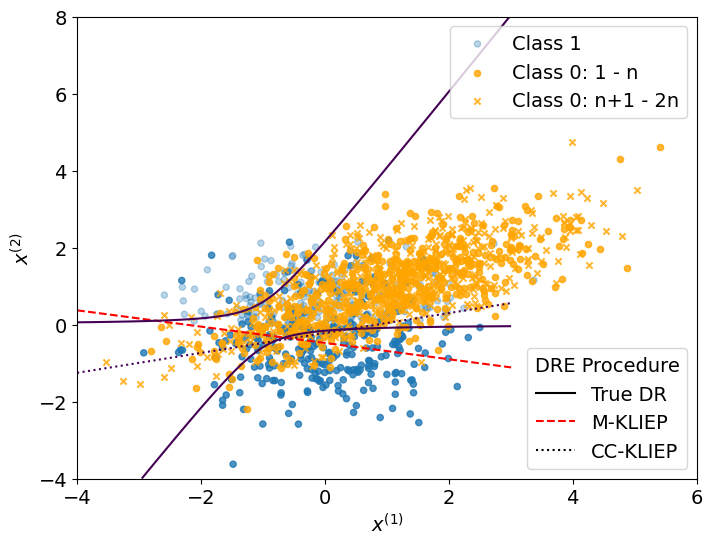

In [14]:
# Set up contour data 
x = torch.linspace(-4, 3, 1000)
y = torch.linspace(-4, 8, 1000)

X, Y = torch.meshgrid(x, y)

X_flat = X.reshape(-1)
Y_flat = Y.reshape(-1)


Z_list=[]
for i in range(3):
    Z_list.append(func_list[i](torch.vstack((X_flat, Y_flat)).T).reshape(1000,1000))

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8, 6))
alpha=np.where(np.isnan(x_plus[:,0]),0.3,0.8)

ax.scatter(x=z_plus[:,0],y=z_plus[:,1],alpha=alpha, s=20,label="Class 1")
ax.scatter(x=z_minus[:,0],y=z_minus[:,1],color="orange",alpha=0.8, s=20, label="Class 0: 1 - n")
ax.scatter(x=z_0_new[:,0],y=z_0_new[:,1],color="orange",marker="x", alpha=0.8,s=20,label="Class 0: n+1 - 2n")

ax.contour(X,Y,Z_list[0],levels=np.array([classif_list[0][0]]),
           linestyles= "dashed",colors=u"r")
ax.contour(X,Y,Z_list[1],levels=np.array([classif_list[1][0]]),
          linestyles="dotted")
ax.contour(X,Y,Z_list[2],levels=np.array([classif_list[2][0]]),
           linestyles="solid")


line1 = mlines.Line2D([], [],color=u"r",linestyle="dashed",label="M-KLIEP")
line2 = mlines.Line2D([], [],color="black",linestyle="dotted",label="CC-KLIEP")
line3 = mlines.Line2D([], [],color="black",linestyle="solid",label="True DR")


# Create a legend for the first line.
leg1 = ax.legend()

ax.legend(handles=[line3,line1,line2],loc="lower right",title="DRE Procedure")
ax.set(xlim=(-4,6),xlabel=r"$x^{(1)}$",ylabel=r"$x^{(2)}$")
ax.add_artist(leg1)

plt.savefig("../plots/NP_classification_Boundary_KLIEP.pdf",bbox_inches="tight", dpi=300)

## 3rd Misspecified Case
$$Z_1\sim N(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, 
\begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix})$$

$$Z_0\sim N(\begin{pmatrix} 1 \\ 1 \end{pmatrix}, 
\begin{pmatrix} 1 & 0\\ 0 & 2\end{pmatrix})$$

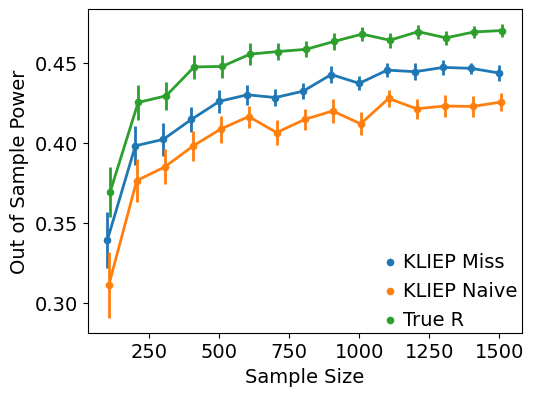

In [15]:
with open('../results/simulated_results/vary_diffvar_misspec2_100sim_comp_diff=1_torch.pkl', 'rb') as handle:
    output = pickle.load(handle)
x = np.arange(100, 1501, 100)
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(output):
    power=torch.tensor(output[key]["poweralpha"])[:,:,0].T
    all_cis = get_ci(power, verbose=False)
    diff=x[1]-x[0]
    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, all_cis[0], label=key, s=20)
    ax.errorbar(x_jit, all_cis[0], all_cis[2]-all_cis[0],linewidth=2)

ax.set(xlabel="Sample Size", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)

plt.savefig("../plots/NP_expected_Power_diffvar_vary_n_one_class.pdf",bbox_inches="tight", dpi=300)

### Single Sample Example

In [16]:
# Set-up data generating functions
n_plus = 500
n_minus = 500
# Generate data generating procedures
cov_mat = torch.tensor([[1, 0], [0, 2]]).float()
diff = 1

plus_dist = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
minus_dist = distributions.MultivariateNormal(torch.zeros(2)+diff, cov_mat)

plus_gen = mv_sampler_creator(n_plus, plus_dist)
minus_gen = mv_sampler_creator(n_minus, minus_dist)
p_0 = 0.8

# Create missing function
def miss_func(x):
    return torch.where(x[:, 1] > 0., p_0, 0.)

# Create true r
def true_r(x):
    return plus_dist.log_prob(x)-minus_dist.log_prob(x)


In [17]:
# Generate data
z_minus = minus_gen()
z_plus = plus_gen()
x_minus = z_minus.clone().detach()
x_plus = z_plus.clone().detach()

# Create corrupted data
u_plus = unif.sample((n_plus,))
x_plus[
    u_plus < miss_func(z_plus), :
] = torch.nan

# Summarise data
dat_vals = get_dat_vals_impute(
    x_plus, x_minus, varphi_plus=miss_func
)

# Perform DRE
out_kliep_miss = kliep_miss_wrap(
    dat_vals, maxiter=1000, opt_type="BFGS",
    f=lambda x:x, norm_fl=True)
out_kliep_naive = kliep_naive_wrap(
    dat_vals, maxiter=1000, opt_type="BFGS",
    f=lambda x:x, norm_fl=True)

out_tup = (out_kliep_miss, out_kliep_naive)

# Do NP classification and construct classifiers
z_0_new = minus_gen()
# Construct classifiers for DR estimates and true DR
func_list = []
classif_list = []
for i in range(2):
    func_list.append(out_tup[i]["r"])
    classif_list.append(cutoff_bin(func_list[i], 0.1, 0.1, z_0_new))

func_list.append(true_r)
classif_list.append(cutoff_bin(true_r,0.1,0.1, z_0_new))

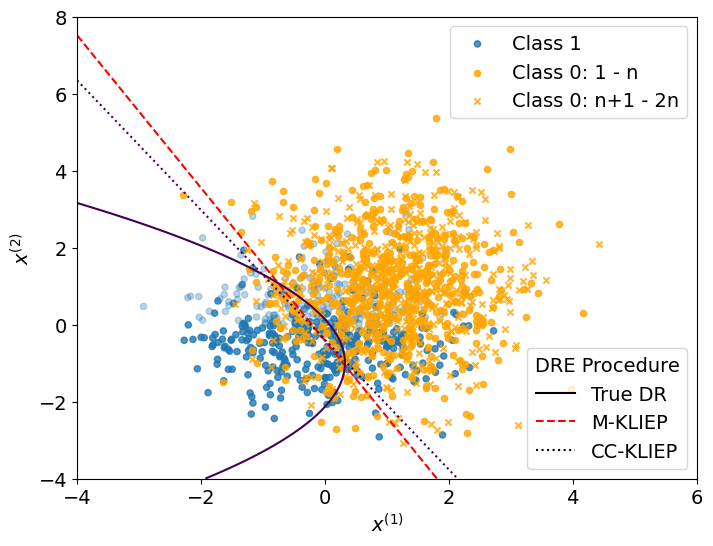

In [18]:
# Set up contour data 
x = torch.linspace(-4, 3, 1000)
y = torch.linspace(-4, 8, 1000)

X, Y = torch.meshgrid(x, y)

X_flat = X.reshape(-1)
Y_flat = Y.reshape(-1)


Z_list=[]
for i in range(3):
    Z_list.append(func_list[i](torch.vstack((X_flat, Y_flat)).T).reshape(1000,1000))

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(8, 6))
alpha=np.where(np.isnan(x_plus[:,0]),0.3,0.8)

ax.scatter(x=z_plus[:,0],y=z_plus[:,1],alpha=alpha, s=20,label="Class 1")
ax.scatter(x=z_minus[:,0],y=z_minus[:,1],color="orange",alpha=0.8, s=20, label="Class 0: 1 - n")
ax.scatter(x=z_0_new[:,0],y=z_0_new[:,1],color="orange",marker="x", alpha=0.8,s=20,label="Class 0: n+1 - 2n")

ax.contour(X,Y,Z_list[0],levels=np.array([classif_list[0][0]]),
           linestyles= "dashed",colors=u"r")
ax.contour(X,Y,Z_list[1],levels=np.array([classif_list[1][0]]),
          linestyles="dotted")
ax.contour(X,Y,Z_list[2],levels=np.array([classif_list[2][0]]),
           linestyles="solid")


line1 = mlines.Line2D([], [],color=u"r",linestyle="dashed",label="M-KLIEP")
line2 = mlines.Line2D([], [],color="black",linestyle="dotted",label="CC-KLIEP")
line3 = mlines.Line2D([], [],color="black",linestyle="solid",label="True DR")


# Create a legend for the first line.
leg1 = ax.legend()

ax.legend(handles=[line3,line1,line2],loc="lower right",title="DRE Procedure")
ax.set(xlim=(-4,6),xlabel=r"$x^{(1)}$",ylabel=r"$x^{(2)}$")
ax.add_artist(leg1)
plt.savefig("../plots/NP_classification_Boundary_diffvar_KLIEP.pdf", format="pdf",bbox_inches="tight", dpi=300)

## Vary Misspecification Level

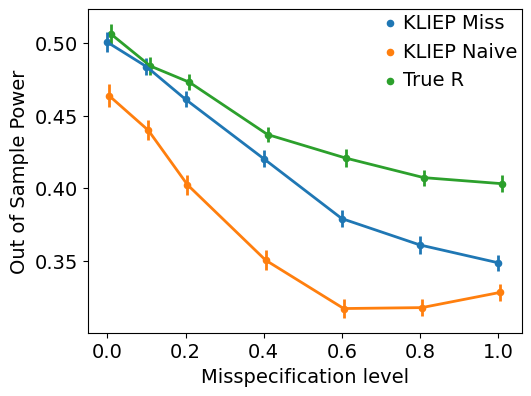

In [19]:
with open('../results/simulated_results/vary_diffvar_misspec3_100sim_comp_diff=1_torch.pkl', 'rb') as handle:
    output = pickle.load(handle)
mix_probs = [1, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5]
x=2*(1-np.array(mix_probs))
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
for i, key in enumerate(output):
    power=torch.tensor(output[key]["poweralpha"])[:,:,0].T
    all_cis = get_ci(power, verbose=False)
    diff=x[1]-x[0]
    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, all_cis[0], label=key, s=20)
    ax.errorbar(x_jit, all_cis[0], all_cis[2]-all_cis[0],linewidth=2)

ax.set(xlabel="Misspecification level", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)
plt.savefig("../plots/NP_expected_Power_varymisspec_one_class.pdf", bbox_inches="tight", dpi=300)

## Naive Bayes Test
Here we test how well performing DRE works under the Naive Bayes assumption when that assumption no longer holds.
$$Z_1\sim N(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, 
\begin{pmatrix} 1 & \rho\\ \rho & 1\end{pmatrix})$$

$$Z_0\sim N(\begin{pmatrix} 1 \\ 1 \end{pmatrix}, 
\begin{pmatrix} 1 & \rho\\ \rho & 1\end{pmatrix})$$

Use $r_\theta(x)=\exp\{\theta^Tx\}$ so that the model is correctly specified.
Vary $\rho$ between $0$ and $1$ and 

$\varphi^1_1(x)=0.8\mathbb{1}\{x>0\}$

$\varphi^1_2(x)=0.8\mathbb{1}\{x<0\}$

$\varphi^0_1=\varphi^0_2\equiv 0.$


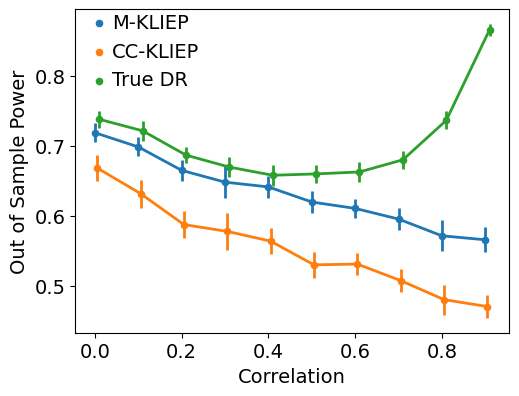

In [20]:
with open('../results/simulated_results/vary_cor_100sim_comp_diff=0.1_torch.pkl', 'rb') as handle:
    output = pickle.load(handle)["Data"]
x = np.linspace(0,0.9,10)
fig, ax = plt.subplots(figsize=(0.7*8, 0.7*6))
labs = {
    "KLIEP Miss": "M-KLIEP", "KLIEP Naive": "CC-KLIEP",
    "True R": "True DR"
    }
for i, key in enumerate(labs):
    power=torch.tensor(output[key]["poweralpha"])[:,:,0].T
    all_cis = get_ci(power, verbose=False)
    diff=x[1]-x[0]
    x_jit = x+diff*0.05*i
    ax.scatter(x_jit, all_cis[0], label=labs[key], s=20)
    ax.errorbar(x_jit, all_cis[0], all_cis[2]-all_cis[0],linewidth=2)

ax.set(xlabel="Correlation", ylabel="Out of Sample Power")
ax.legend(handletextpad=-0.3,borderpad=0, borderaxespad=0.2,frameon=False)
plt.savefig("../plots/NP_expected_Power_naive_bayes_vary_n_one_class.pdf", bbox_inches="tight", dpi=300)
